In [1]:
# http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

In [3]:
# import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

Posing the problem as a classification task is probably not ideal. We are asking our NN to learn to recognize a whale out of 5004 possible candidates based on what it has learned about the whales. That is a tall order.

Instead, here we will try to pose the problem as a verification task. When presented with two images of whale flukes, we will ask the network - are the images of the same whale or of different whales? In particular, we will try to teach our network to learn features that can be useful in determining the similarity between whale images (hence the name of this approach - feature learning).

This seems like a much easier task, at least in theory. Either way, no need to start with a relatively big CNN like resnet50. Let's see what mileage we can get out of resnet18.

In [3]:
# new architecture calls for a new validation set, this time our validation set will consist of all whales that have exactly two images
df = pd.read_csv('data/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df[df.sighting_count == 2].Image)

In [4]:
len(val_fns)

2570

In [5]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

name = f'res18-siamese'

In [6]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [7]:
# data_block api creates categories based on classes it sees in the train set and
# our val set contains whales whose ids do not appear in the train set
classes = df.Id.unique()

In [8]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
#         .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
#         .normalize(imagenet_stats)
)

I am still using the ImageItemList even though I will create my own datasets. Why? Because I want to reuse the functionality that is already there (creating datasets from files, augmentations, resizing, etc).

I realize the code is neither clean nor elegant but for the time being I am happy with this approach.

In [9]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.whale_ids = ds.y.items
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_same(idx // 2)
        else: return self.sample_different((idx-1) // 2)
    def sample_same(self, idx):
        whale_id = self.whale_ids[idx]        
        candidates = list(np.where(self.whale_ids == whale_id)[0])
        candidates.remove(idx) # dropping our current whale - we don't want to compare against an identical image!
        
        if len(candidates) == 0: # oops, there is only a single whale with this id in the dataset
            return self.sample_different(idx)
        
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 1)
    def sample_different(self, idx):
        whale_id = self.whale_ids[idx]
        candidates = list(np.where(self.whale_ids != whale_id)[0])
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 0)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [10]:
train_dl = DataLoader(
    TwoImDataset(data.train),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_dl = DataLoader(
    TwoImDataset(data.valid),
    batch_size=BS,
    shuffle=False,
    num_workers=NUM_WORKERS
)

data_bunch = ImageDataBunch(train_dl, valid_dl)

In [11]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [12]:
data_bunch.add_tfm(normalize_batch)

In [13]:
from functional import seq

class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = nn.Linear(num_features_model(self.cnn), 1)
        
    def forward(self, im_A, im_B):
        # dl - distance layer
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        dl = self.calculate_distance(x1, x2)
        out = self.head(dl)
        return out
    
    def process_features(self, x): return x.reshape(*x.shape[:2], -1).max(-1)[0]
    def calculate_distance(self, x1, x2): return (x1 - x2).abs_()
    

Below I include two slightly different siamese networks. I leave the code commented out and choose to use the one above.

In [16]:
# from functional import seq

# def cnn_activations_count(model):
#     _, ch, h, w = model_sizes(create_body(models.resnet18), (SZ, SZ))[-1]
#     return ch * h * w

# class SiameseNetwork(nn.Module):
#     def __init__(self, lin_ftrs=2048, arch=models.resnet18):
#         super().__init__() 
#         self.cnn = create_body(arch)
#         self.fc1 = nn.Linear(cnn_activations_count(self.cnn), lin_ftrs)
#         self.fc2 = nn.Linear(lin_ftrs, 1)
        
#     def forward(self, im_A, im_B):
#         x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features).map(self.fc1)
#         dl = self.calculate_distance(x1.sigmoid(), x2.sigmoid())
#         out = self.fc2(dl)
#         return out
    
#     def calculate_distance(self, x1, x2): return (x1 - x2).abs_()
#     def process_features(self, x): return x.reshape(x.shape[0], -1)

In [17]:
# from functional import seq

# def cnn_activations_count(model):
#     _, ch, h, w = model_sizes(create_body(models.resnet18), (SZ, SZ))[-1]
#     return ch * h * w

# class SiameseNetwork(nn.Module):
#     def __init__(self, lin_ftrs=2048, pool_to=3, arch=models.resnet18, pooling_layer=nn.AdaptiveMaxPool2d):
#         super().__init__() 
#         self.cnn = create_body(arch)
#         self.pool = pooling_layer(pool_to)
#         self.fc1 = nn.Linear(num_features_model(self.cnn) * pool_to**2, lin_ftrs)
#         self.fc2 = nn.Linear(lin_ftrs, 1)
        
#     def forward(self, im_A, im_B):
#         x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.pool).map(self.process_features).map(self.fc1)
#         dl = self.calculate_distance(x1.sigmoid(), x2.sigmoid())
#         out = self.fc2(dl)
#         return out
    
#     def calculate_distance(self, x1, x2): return (x1 - x2).abs_()
#     def process_features(self, x): return x.reshape(x.shape[0], -1)

In [14]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [19]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [20]:
learn.freeze_to(-1)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


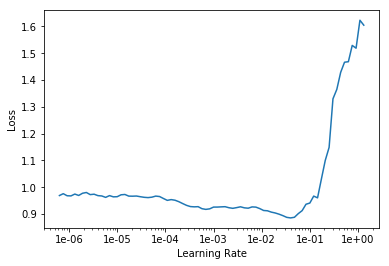

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,
1,0.525171,0.736362,0.532685
2,0.409036,0.425513,0.759533
3,0.369458,0.314608,0.868093
4,0.328593,0.296097,0.857588


In [24]:
learn.save(f'{name}-stage-1')

In [25]:
learn.unfreeze()

In [26]:
max_lr = 5e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [27]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,
1,0.299970,0.285136,0.863424
2,0.286753,0.260144,0.887743
3,0.277695,0.269493,0.872763
4,0.259490,0.234493,0.895720
5,0.229194,0.224973,0.912257
6,0.217003,0.232760,0.897082
7,0.202161,0.215272,0.907977
8,0.203944,0.228468,0.894163
9,0.201418,0.222140,0.896498
10,0.198599,0.217933,0.899416


In [28]:
learn.save(f'{name}-stage-2')

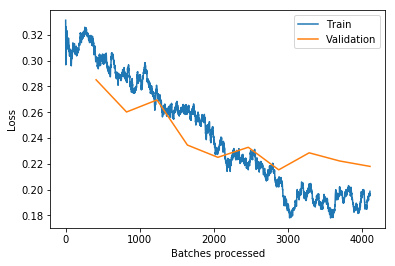

In [29]:
learn.recorder.plot_losses()

The model is not doing that well - out of presented pairs it gets roughly 10% of examples wrong. I also did a cursory error analysis (not shown here for the sake of brevity) and the model is not doing that great at all.

How can this be? Maybe the nearly absolute positional invariance through the use of global max pooling is not working that well. Maybe there is a bug somewhere? Maybe the model has not been trained for long enough or lacks capacity?

If I do continue to work on this I will definitely take a closer look at each of the angles I list above. For the time being, let's try to predict on the validation set and finish off with making a submission.

The predicting part is where the code gets really messy. That is good enough for now though.

In [15]:
learn.load(f'{name}-stage-2');

In [16]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:1000])

In [17]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns))
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [18]:
len(data.valid_ds)

3570

In [19]:
%%time
targs = []
feats = []
learn.model.eval()
for ims, ts in data.valid_dl:
    feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    targs.append(ts)

CPU times: user 1.93 s, sys: 1.13 s, total: 3.06 s
Wall time: 3.57 s


In [20]:
feats = torch.cat(feats)

In [21]:
feats.shape

torch.Size([3570, 512])

In [22]:
%%time
sims = []
for feat in feats:
    dists = learn.model.calculate_distance(feats, feat.unsqueeze(0).repeat(3570, 1))
    predicted_similarity = learn.model.head(dists.cuda()).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 21.5 s, sys: 0 ns, total: 21.5 s
Wall time: 21.5 s


In [23]:
len(sims)

3570

In [24]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]

In [44]:
%%time
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.19 s


In [45]:
# without predicting new_whale
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.25805322128851543

In [46]:
%%time

for thresh in np.linspace(0.98, 1, 10):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == new_whale_idx or j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    print(thresh, mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5))

0.98 0.28244631185807656
0.9822222222222222 0.2875023342670402
0.9844444444444445 0.2908216619981326
0.9866666666666667 0.29868347338935575
0.9888888888888889 0.3054715219421102
0.991111111111111 0.3146778711484594
0.9933333333333333 0.32679271708683477
0.9955555555555555 0.3353548085901027
0.9977777777777778 0.34555555555555556
1.0 0.3471428571428572
CPU times: user 12.9 s, sys: 0 ns, total: 12.9 s
Wall time: 12.9 s


There are many reasons why the best threshold here might not carry over to what would make sense on the test set. It is some indication though of how our model is doing and a useful data point.

## Predict

In [163]:
len(data.test_ds)

7960

In [189]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in {'69823499d.jpg'}) # in newer version of the fastai library there is .no_split that could be used here
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(None, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [190]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())

CPU times: user 2.9 s, sys: 1.79 s, total: 4.69 s
Wall time: 5.03 s


In [195]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    train_class_idxs.append(t)

CPU times: user 9.02 s, sys: 5.04 s, total: 14.1 s
Wall time: 14.4 s


In [196]:
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

In [206]:
test_feats = torch.cat(test_feats)

In [209]:
%%time
sims = []
for feat in test_feats:
    dists = learn.model.calculate_distance(train_feats, feat.unsqueeze(0).repeat(25344, 1))
    predicted_similarity = learn.model.head(dists.cuda()).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 5min 7s, sys: 2min 58s, total: 8min 6s
Wall time: 8min 6s


In [211]:
%%time
thresh = 1

top_5s = []
for sim in sims:
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for i, p in zip(idxs, probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 19.6 s, sys: 128 ms, total: 19.7 s
Wall time: 19.7 s


In [221]:
top_5_classes = []
for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [222]:
top_5_classes[:5]

['new_whale w_9bedea6 w_448e190 w_ab629bb w_67e9aa8',
 'new_whale w_edce644 w_dd79a10 w_99af1a9 w_ae393cd',
 'new_whale w_4516ff1 w_d1207d9 w_02c7e9d w_8003858',
 'new_whale w_0369a5c w_f66ec54 w_ae8982d w_d0475b2',
 'new_whale w_8cd5c91 w_0cc0430 w_06460d7 w_e8b82f6']

In [223]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [224]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,47380533f.jpg,new_whale w_9bedea6 w_448e190 w_ab629bb w_67e9aa8
1,1d9de38ba.jpg,new_whale w_edce644 w_dd79a10 w_99af1a9 w_ae393cd
2,b3d4ee916.jpg,new_whale w_4516ff1 w_d1207d9 w_02c7e9d w_8003858
3,460fd63ae.jpg,new_whale w_0369a5c w_f66ec54 w_ae8982d w_d0475b2
4,79738ffc1.jpg,new_whale w_8cd5c91 w_0cc0430 w_06460d7 w_e8b82f6


In [225]:
pd.read_csv(f'subs/{name}.csv.gz').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

1.0

In [226]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|████████████████████████████████████████| 164k/164k [00:03<00:00, 46.1kB/s]
Successfully submitted to Humpback Whale Identification